# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,127875690.0,38.119,-54.480,8.96,224,800.0,805.0,1580.9,0,271,0.00000,0.0
1,127875700.0,38.118,-54.489,8.96,224,807.0,801.0,1596.0,0,271,0.00721,10.0
2,127875710.0,38.119,-54.498,8.96,224,813.0,809.0,1593.2,0,271,0.01442,20.0
3,127875720.0,38.119,-54.508,8.96,224,813.0,824.0,1573.0,0,271,0.02163,30.0
4,127875730.0,38.121,-54.515,8.96,224,820.0,825.0,1581.0,0,271,0.02884,40.0


Generate a temperature matrix

In [2]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [36]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
#x_range = (27, 37)
#y_range = (-66, -56)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_5856\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_5856\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [33]:
list_25l.shape

(25, 101, 101)

# Detect pixel anomalies

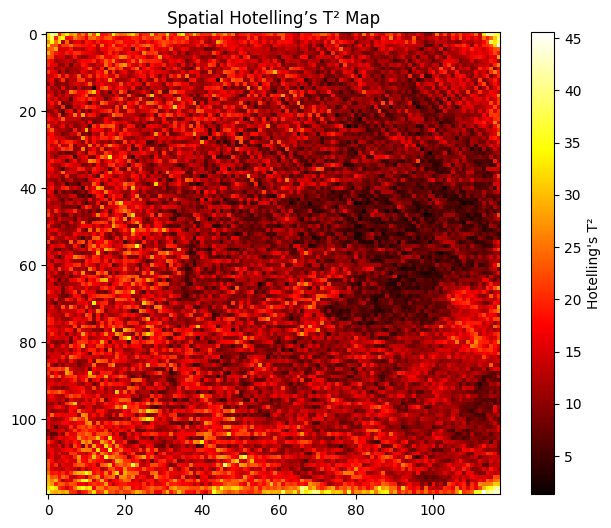

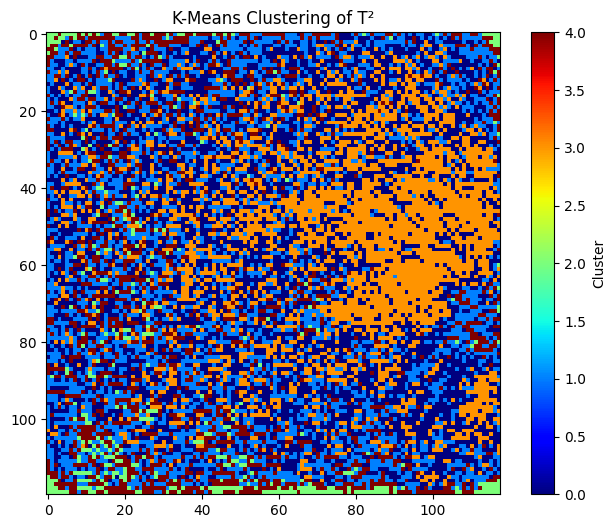

In [9]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming list_25l is a numpy array of shape (25, 120, 118)
frames = np.array(list_25l)  # shape: (J, M, N)
J, M, N = frames.shape
p = M * N

# Step 1: Reshape (unfold) the data: each pixel across time is a row
X = frames.reshape(J, -1).T  # Shape becomes (p, J)

# Step 2: Apply PCA
n_components = min(J, p)
pca = PCA(n_components=n_components)
scores = pca.fit_transform(X)

# Step 3: Compute Hotelling’s T² statistic for each pixel
# T² = z.T @ Λ⁻¹ @ z where z is the score vector and Λ the eigenvalues (variance)
# We'll use the top m components that explain >=80% of the variance
explained = np.cumsum(pca.explained_variance_ratio_)
m = np.searchsorted(explained, 0.80) + 1
Z = scores[:, :m]
Lambda_inv = np.diag(1 / pca.explained_variance_[:m])
T2 = np.sum(Z @ Lambda_inv * Z, axis=1)

# Step 4: Reshape T² back into spatial format
T2_map = T2.reshape(M, N)

# Step 5: Visualize
plt.figure(figsize=(8, 6))
plt.imshow(T2_map, cmap='hot')
plt.colorbar(label="Hotelling's T²")
plt.title("Spatial Hotelling’s T² Map")
plt.show()

# Step 6 (Optional): K-means clustering on T² map to identify hotspots
kmeans = KMeans(n_clusters=5, random_state=0).fit(T2_map.reshape(-1, 1))
clusters = kmeans.labels_.reshape(M, N)

# Visualize clusters
plt.figure(figsize=(8, 6))
plt.imshow(clusters, cmap='jet')
plt.title("K-Means Clustering of T²")
plt.colorbar(label="Cluster")
plt.show()


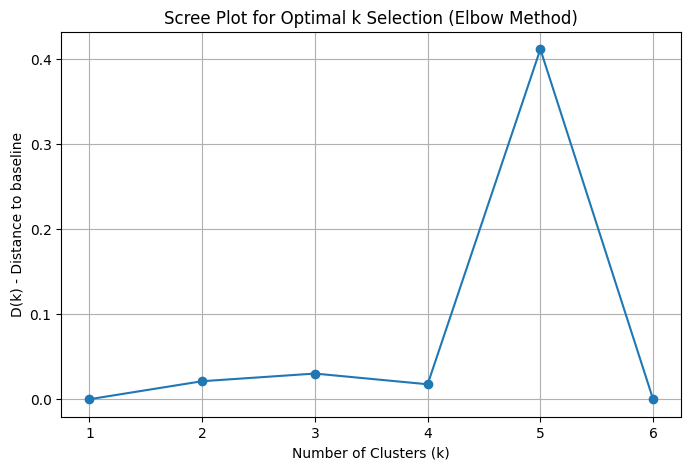

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
import numpy as np

# Flatten T2_map to 1D for clustering
T2_flat = T2_map.flatten().reshape(-1, 1)
K_range = range(1, 7)
SSW = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
    labels = kmeans.fit_predict(T2_flat)
    _, dists = pairwise_distances_argmin_min(kmeans.cluster_centers_[labels], T2_flat)
    ssw_k = np.sum(dists ** 2)
    SSW.append(ssw_k)

# Convert SSW to D(k) using the "distance to line" (elbow method)
# Line between (1, SSW[0]) and (K_max, SSW[-1])
x = np.array(list(K_range))
y = np.array(SSW)

# Create the line
x1, y1 = x[0], y[0]
x2, y2 = x[-1], y[-1]

# Compute distance from each point to the line
Dk = np.abs((y2 - y1) * x - (x2 - x1) * y + x2*y1 - y2*x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

# Plot D(k) (scree/elbow plot)
plt.figure(figsize=(8, 5))
plt.plot(K_range, Dk, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("D(k) - Distance to baseline")
plt.title("Scree Plot for Optimal k Selection (Elbow Method)")
plt.grid(True)
plt.show()


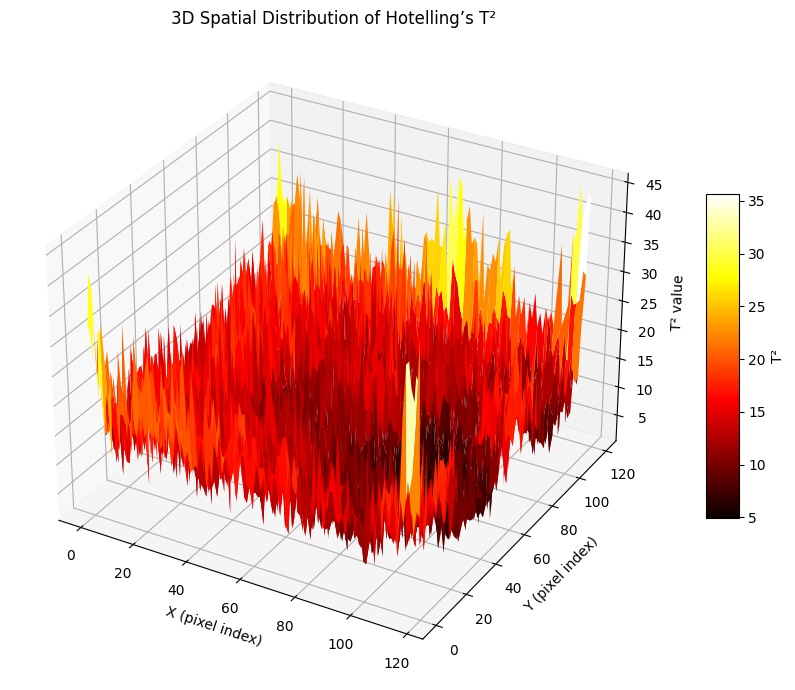

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Assuming T2_map is already computed and has shape (M, N)
M, N = T2_map.shape
X, Y = np.meshgrid(np.arange(N), np.arange(M))  # Coordinate grid

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, T2_map, cmap='hot', edgecolor='none')

ax.set_title("3D Spatial Distribution of Hotelling’s T²")
ax.set_xlabel("X (pixel index)")
ax.set_ylabel("Y (pixel index)")
ax.set_zlabel("T² value")
fig.colorbar(surf, shrink=0.5, aspect=10, label="T²")

plt.tight_layout()
plt.show()


# References
* [In-Process Monitoring of Selective Laser Melting: Spatial Detection of Defects Via Image Data Analysis](https://re.public.polimi.it/bitstream/11311/1016879/6/in-process%20monitoring%20of%20slm.pdf)

# Further improvements

* try batching in 2 consecutive layers or the incremental approach in the paper